<a href="https://colab.research.google.com/github/Simoni2412/Dark_Circles_Detection/blob/main/DarkCircles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install a specific, compatible version of OpenCV
!pip install opencv-contrib-python-headless==4.8.0.74
# Install a specific, compatible version of numpy
!pip install numpy==1.24.3

!pip install --upgrade --force-reinstall mediapipe==0.10.5


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 88.9 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.24.3 which is incompatible.
albucore 0.0.24 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.3 which is incompatible.
xarray-einstats 0.9.0 requires numpy>=1.25, but you have numpy 1.24.3 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.24.3 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.3 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 467.2/467.2 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 109.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

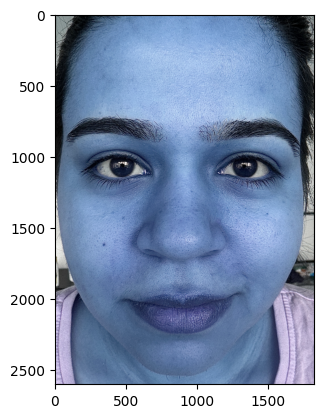

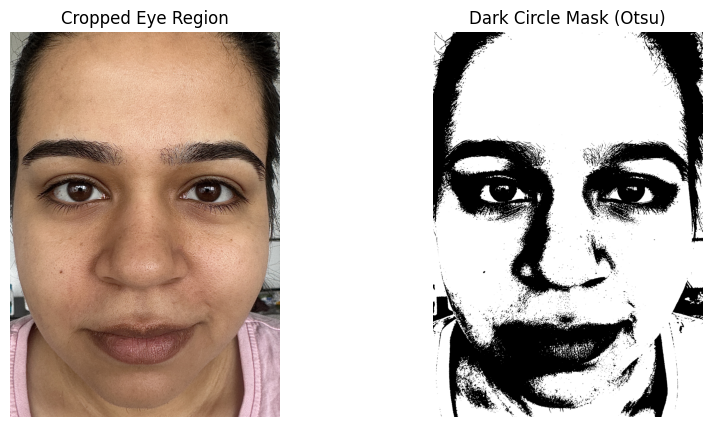

In [ ]:
# Assuming necessary imports (cv2, numpy, mediapipe, etc.) are present
# Assuming mp_face_mesh and face_mesh are initialized globally or within a class

# Define landmark indices for eye regions (using outer contours)
# From previous turn, adjusted for both eyes
EYE_LANDMARK_INDICES = [
    33, 246, 161, 160, 159, 158, 157, 173, 133, 155, 154, 153, 145, 144, 163, 7, # Left eye outer contour
    263, 466, 388, 387, 386, 385, 384, 398, 362, 380, 379, 378, 377, 374, 373, 283 # Right eye outer contour
]
 # Initialize MediaPipe Face Mesh
mp_face_mesh = mp.solutions.face_mesh

def get_landmark_coords(image, landmarks, indexes):
    """Extracts pixel coordinates for given landmark indexes."""
    h, w = image.shape[:2]
    # Ensure indexes are within bounds
    valid_indexes = [i for i in indexes if i is not None and 0 <= i < len(landmarks)]
    return np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in valid_indexes], np.int32)

def detect_landmarks(image):
    """ Detect facial landmarks using Mediapipe """
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1) as face_mesh:
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            return landmarks
    return []

def detect_dark_circles_otsu(image_path):
    """
    Detects dark circles in the eye region using landmark-based cropping and Otsu's thresholding.

    Args:
        image_path (str): Path to the input image file.

    Returns:
        Tuple: (cropped_eye_region, dark_circle_mask).
               cropped_eye_region is the cropped image around the eyes.
               dark_circle_mask is the binary mask of potential dark circles
               within the cropped region.
               Returns (None, None) if face or eye region detection fails.
    """

    # Read the image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Could not read image file at path: {image_path}")
        return None, None

    # --- Corrected: Detect facial landmarks by calling detect_landmarks ---
    landmarks = detect_landmarks(image)


    if not landmarks: # Check if landmarks were successfully detected and returned
        print(f"No face detected or landmarks found in {image_path}.")
        return None, None

    # Use the returned landmarks object
    face_landmarks = landmarks.landmark
    h_orig, w_orig = image.shape[:2]

    # Get coordinates for the eye region landmarks
    # Pass the landmarks.landmark object to get_landmark_coords
    eye_pts = get_landmark_coords(image, face_landmarks, EYE_LANDMARK_INDICES)

    if eye_pts.size == 0:
        print(f"Could not get valid eye landmark coordinates in {image_path}.")
        return None, None


    # Calculate bounding box around eye landmarks
    x_min = np.min(eye_pts[:, 0])
    y_min = np.min(eye_pts[:, 1])
    x_max = np.max(eye_pts[:, 0])
    y_max = np.max(eye_pts[:, 1])

    # Add a buffer to the bounding box, especially downwards to include dark circle area
    # Adjust buffer_x and buffer_y based on how much area around eyes you need
    buffer_x = int((x_max - x_min) * 0.2) # 20% horizontal buffer
    buffer_y_top = int((y_max - y_min) * 0.5) # 50% buffer upwards (to catch upper eyelid/brow)
    buffer_y_bottom = int((y_max - y_min) * 1.0) # 100% buffer downwards (to catch dark circles)


    x_min = max(0, x_min - buffer_x)
    y_min = max(0, y_min - buffer_y_top)
    x_max = min(w_orig, x_max + buffer_x)
    y_max = min(h_orig, y_max + buffer_y_bottom)

    # Ensure bounding box is valid
    if x_max <= x_min or y_max <= y_min:
         print(f"Invalid bounding box calculated for eye region in {image_path}.")
         return None, None

    # Crop the image to the eye region
    cropped_eye_region = image[y_min:y_max, x_min:x_max]
    plt.imshow(cropped_eye_region)
    plt.show()

    # Check if cropped region is not empty
    if cropped_eye_region.shape[0] == 0 or cropped_eye_region.shape[1] == 0:
        print(f"Cropped eye region is empty for {image_path}.")
        return None, None


    # Convert the cropped region to grayscale
    gray_eye_region = cv2.cvtColor(cropped_eye_region, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise before thresholding (optional but recommended)
    blurred_eye_region = cv2.GaussianBlur(gray_eye_region, (5, 5), 0) # Adjust kernel size as needed

    # Apply Otsu's thresholding
    # Otsu's method finds the optimal global threshold value
    ret, dark_circle_mask = cv2.threshold(blurred_eye_region, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # The mask will have 255 for the foreground (potentially dark circles) and 0 for background.
    # Depending on the image and threshold, sometimes the dark areas become background (0).
    # You might need to invert the mask if the dark circles appear as 0 in the output.
    # A common pattern for dark areas is they are below the threshold, resulting in 0.
    # So, if you expect dark circles to be the foreground (255), you might need to invert:
    # dark_circle_mask = cv2.bitwise_not(dark_circle_mask) # Uncomment if inversion is needed


    return cropped_eye_region, dark_circle_mask

# --- Example Usage ---
# Assuming you have a sample image path
sample_image_for_dark_circles = "/content/drive/MyDrive/Dataset /Originals/IMG_9754.jpg" # Replace with a real path

cropped_eye, dark_circle_mask = detect_dark_circles_otsu(sample_image_for_dark_circles)

if cropped_eye is not None and dark_circle_mask is not None:
    # Visualize the results
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    # OpenCV reads as BGR, Matplotlib expects RGB. Convert back for display if needed.
    plt.imshow(cv2.cvtColor(cropped_eye, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Eye Region')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(dark_circle_mask, cmap='gray') # Thresholded mask is grayscale 0 or 255
    plt.title('Dark Circle Mask (Otsu)')
    plt.axis('off')

    plt.show()
else:
    print("Could not process the image for dark circle detection.")


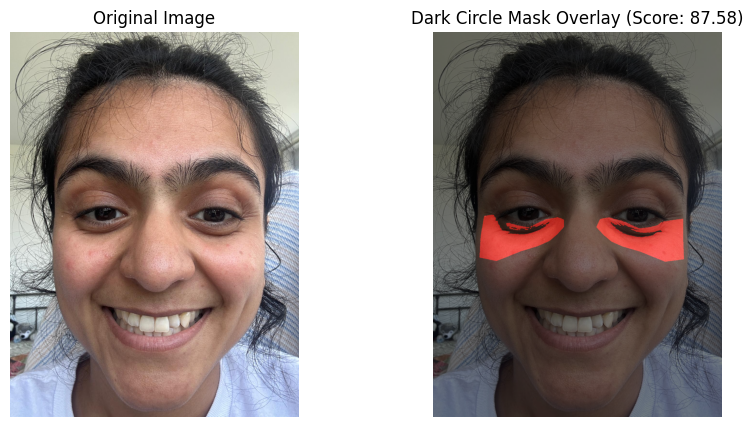

Calculated Dark Circle Score: 87.58


In [59]:
# import cv2
# import numpy as np
# import mediapipe as mp
# import matplotlib.pyplot as plt # Assuming matplotlib is available for visualization

# Assuming necessary imports (cv2, numpy, mediapipe, matplotlib) are present

# Define landmark indices for LEFT and RIGHT eye regions (using outer contours)

# #wide mask
# LEFT_EYE_IDXS = [
#     35, 226, 7, 163, 144, 145, 153, 154, 243, 244, 245, 188, 114, 47, 100, 101, 50, 123, 116, 143]  # Left eye outer contour4

# RIGHT_EYE_IDXS = [
#     463, 464, 465, 412, 343, 277, 329, 330, 280, 352, 345, 372, 249, 390, 373, 374, 380, 381, 341 # Right eye outer contour
# ]

#only outside the eye
LEFT_EYE_IDXS = [
    35, 226, 25, 110, 24, 23, 154, 243, 112, 243, 244, 245, 188, 114, 47, 100, 101, 50, 123, 116, 143]  # Left eye outer contour4

RIGHT_EYE_IDXS = [
    463, 464, 465, 412, 343, 277, 329, 330, 280, 352, 345, 372, 255, 339, 254, 253, 381# Right eye outer contour
]

# Small mask
# RIGHT_EYE_IDXS = [
#     463, 464, 465, 357, 350, 349, 348, 347, 346, 340, 265, 446, 249, 390, 373, 374, 380, 381, 398, 463 # Right eye outer contour
# ]

# LEFT_EYE_IDXS = [
#     35, 226, 7, 163, 144, 145, 153, 154, 243, 244, 245, 128, 121, 120, 119, 118, 117, 111, 143]


 # Initialize MediaPipe Face Mesh (keep this global)
mp_face_mesh = mp.solutions.face_mesh

# get_landmark_coords function remains as you provided it
def get_landmark_coords(image, landmarks, indexes):
    """Extracts pixel coordinates for given landmark indexes."""
    h, w = image.shape[:2]
    # Ensure indexes are within bounds
    valid_indexes = [i for i in indexes if i is not None and 0 <= i < len(landmarks)]
    return np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in valid_indexes], np.int32)


# segment_facial_regions function is not used in the updated dark circle detection


def different_zones(image, landmarks):
    """ Generate segmented facial region masks and segments for left/right eyes """
    h, w = image.shape[:2]

    # Convert landmark coordinates to pixel positions
    left_eye_pts = get_landmark_coords(image, landmarks.landmark, LEFT_EYE_IDXS)
    right_eye_pts = get_landmark_coords(image, landmarks.landmark, RIGHT_EYE_IDXS)

    # Initialize blank masks for each region (size of original image)
    left_eye_mask_full = np.zeros((h, w), dtype=np.uint8)
    right_eye_mask_full = np.zeros((h, w), dtype=np.uint8)

    # Fill masks with corresponding regions (using 255 for filled area)
    if left_eye_pts.size > 0:
        cv2.fillPoly(left_eye_mask_full, [np.array(left_eye_pts, dtype=np.int32)], 255)  # Left eye region
    if right_eye_pts.size > 0:
        cv2.fillPoly(right_eye_mask_full, [np.array(right_eye_pts, dtype=np.int32)], 255)  # Right eye region

    # Extract segmented images using individual masks (size of original image)
    left_eye_segment = cv2.bitwise_and(image, image, mask=left_eye_mask_full)
    right_eye_segment = cv2.bitwise_and(image, image, mask=right_eye_mask_full)

    # Also return the filled masks for later use in scoring/combining
    return left_eye_segment, right_eye_segment, left_eye_mask_full, right_eye_mask_full

def apply_clahe(image_gray):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image_gray)

def detect_dark_circles_otsu(image_path):
    """
    Detects dark circles in the left and right eye regions separately
    using landmark-based segmentation and Otsu's thresholding.

    Args:
        image_path (str): Path to the input image file.

    Returns:
        Tuple: (original_image, combined_dark_circle_mask_full_size, dark_circle_score).
               Returns (None, None, None) if face or eye region detection fails.
    """

    # Read the image
    original_image = cv2.imread(image_path)

    if original_image is None:
        print(f"Error: Could not read image file at path: {image_path}")
        return None, None, None

    # Convert to RGB for MediaPipe
    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    h_orig, w_orig = original_image.shape[:2]

    # --- Initialize and use FaceMesh directly within this function ---
    with mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True) as face_mesh:
        results = face_mesh.process(rgb_image)

    if not results.multi_face_landmarks:
        print(f"No face detected in {image_path}.")
        return original_image, np.zeros((h_orig, w_orig), dtype=np.uint8), 0.0 # Return original image and empty mask

    landmarks = results.multi_face_landmarks[0]

    # Get segmented eye regions (same size as original image) and the masks
    left_segment, right_segment, left_eye_mask_full, right_eye_mask_full = different_zones(original_image, landmarks)

    # Initialize masks for detected dark circles (full size)
    left_dark_circle_mask_full_size = np.zeros((h_orig, w_orig), dtype=np.uint8)
    right_dark_circle_mask_full_size = np.zeros((h_orig, w_orig), dtype=np.uint8)


    # Process Left Eye Segment
    if left_segment.shape[0] > 0 and left_segment.shape[1] > 0 and np.max(left_segment) > 0: # Check if segment is valid and not all black
        gray_left_eye = cv2.cvtColor(left_segment, cv2.COLOR_BGR2GRAY)
        gray_left_eye = apply_clahe(gray_left_eye)

        # Apply Gaussian blur (check kernel size)
        ksize = (7, 7) # Must be odd
        if gray_left_eye.shape[0] >= ksize[0] and gray_left_eye.shape[1] >= ksize[1]:
             blurred_left_eye = cv2.GaussianBlur(gray_left_eye, ksize, 0)
        else:
             print(f"Left eye segment size too small for blur kernel {ksize} in {image_path}.")
             blurred_left_eye = gray_left_eye # Skip blur if too small

        # Apply Otsu's thresholding to the left eye segment
        try:
             # THRESH_BINARY_INV might be better if dark circles are lower intensity
             ret_left, thresh_left = cv2.threshold(blurred_left_eye, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Removed + cv2.THRESH_OTSU
             # You might need to invert if dark circles appear as 0
             # ret_left, thresh_left = cv2.threshold(blurred_left_eye, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
             left_dark_circle_mask_full_size = thresh_left # This mask is already full size
        except cv2.error as e:
            print(f"Error during left eye thresholding for {image_path}: {e}")


    # Process Right Eye Segment
    if right_segment.shape[0] > 0 and right_segment.shape[1] > 0 and np.max(right_segment) > 0: # Check if segment is valid and not all black
        gray_right_eye = cv2.cvtColor(right_segment, cv2.COLOR_BGR2GRAY)
        gray_right_eye = apply_clahe(gray_right_eye)

        # Apply Gaussian blur (check kernel size)
        ksize = (7, 7) # Must be odd
        if gray_right_eye.shape[0] >= ksize[0] and gray_right_eye.shape[1] >= ksize[1]:
             blurred_right_eye = cv2.GaussianBlur(gray_right_eye, ksize, 0)
        else:
             print(f"Right eye segment size too small for blur kernel {ksize} in {image_path}.")
             blurred_right_eye = gray_right_eye # Skip blur if too small

        # Apply Otsu's thresholding to the right eye segment
        try:
             # THRESH_BINARY_INV might be better if dark circles are lower intensity
             ret_right, thresh_right = cv2.threshold(blurred_right_eye, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # Removed + cv2.THRESH_OTSU
             # You might need to invert if dark circles appear as 0
             # ret_right, thresh_right = cv2.threshold(blurred_right_eye, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
             right_dark_circle_mask_full_size = thresh_right # This mask is already full size
        except cv2.error as e:
            print(f"Error during right eye thresholding for {image_path}: {e}")


    # Combine the left and right dark circle masks (full size)
    # Use bitwise_or to combine the binary masks
    combined_dark_circle_mask_full_size = cv2.bitwise_or(left_dark_circle_mask_full_size, right_dark_circle_mask_full_size)

    # --- Optional: Refine the combined mask ---
    # Apply morphological operations to clean up the mask (e.g., remove small noise)
    kernel = np.ones((3, 3), np.uint8)
    combined_dark_circle_mask_full_size = cv2.morphologyEx(combined_dark_circle_mask_full_size, cv2.MORPH_OPEN, kernel) # Opening to remove small objects

    # --- Erode the mask to remove border artifacts ---
    kernel_erode = np.ones((3, 3), np.uint8)  # Try (3,3) or (5,5)
    combined_dark_circle_mask = cv2.erode(combined_dark_circle_mask_full_size, kernel_erode, iterations=1)

    # --- Calculate Dark Circle Score ---
    # A simple score can be based on the proportion of detected dark circle pixels
    # within the total eye region area.
    total_eye_region_mask = cv2.bitwise_or(left_eye_mask_full, right_eye_mask_full) # Combine the original eye region masks
    total_eye_pixel_count = np.sum(total_eye_region_mask > 0) # Count non-zero pixels in the eye region mask

        # After you create total_eye_region_mask
    kernel_inner = np.ones((5, 5), np.uint8)  # Try (7,7) or (9,9) for a strong shrink
    inner_eye_mask = cv2.erode(total_eye_region_mask, kernel_inner, iterations=1)

    # Create a boolean mask for dark pixels within the eye region
    dark_pixels_mask = (combined_dark_circle_mask == 0) & (inner_eye_mask > 0)

    dark_circle_pixel_count = np.sum((combined_dark_circle_mask_full_size > 0)) # Count non-zero pixels in the dark circle mask

    dark_circle_score = 0.0
    if total_eye_pixel_count > 0:
        dark_circle_score = (dark_circle_pixel_count / total_eye_pixel_count) * 100 # Score as percentage of eye area

    # You could refine the score calculation, e.g., consider intensity within the dark circle mask on the original image.
    # E.g., mean_intensity_in_dark_circles = cv2.mean(original_image, mask=combined_dark_circle_mask_full_size)
    # A lower intensity might indicate more severe dark circles. You could incorporate this.

    return original_image, combined_dark_circle_mask_full_size, dark_circle_score, dark_pixels_mask


# --- Example Usage ---
#Assuming you have a sample image path
sample_image_for_dark_circles = "/content/test.jpg" # Replace with a real path
#sample_image_for_dark_circles = "/content/darkcircle.jpeg"
original_img, dark_circle_mask, score, dark_pixels_mask1 = detect_dark_circles_otsu(sample_image_for_dark_circles)

if original_img is not None and dark_circle_mask is not None:
    # Visualize the results
    plt.figure(figsize=(10, 5))

    # Display the original image
    plt.subplot(1, 2, 1)
    # OpenCV reads as BGR, Matplotlib expects RGB. Convert back for display.
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    # Display the dark circle mask overlaid on the original image
    plt.subplot(1, 2, 2)
    # Create a color overlay for the mask (e.g., red)
    overlay = np.zeros_like(original_img, dtype=np.uint8)
    # Set the color (BGR format for OpenCV) for the mask pixels
    overlay[dark_circle_mask > 0] = [0, 0, 255] # Red color where mask is non-zero

    # Blend the overlay with the original image
    alpha = 0.5 # Transparency factor
    overlaid_image = cv2.addWeighted(original_img, 1 - alpha, overlay, alpha, 0)

    plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Dark Circle Mask Overlay (Score: {score:.2f})')
    plt.axis('off')

    plt.show()
    print(f"Calculated Dark Circle Score: {score:.2f}")

else:
    print("Could not process the image for dark circle detection.")

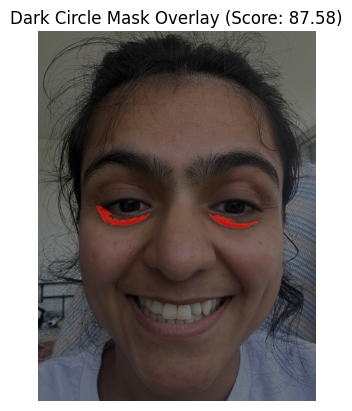

In [60]:

# Assume original_img, combined_dark_circle_mask_full_size, total_eye_region_mask are already defined

# Create an overlay image (same size as original)
overlay = np.zeros_like(original_img, dtype=np.uint8)

# # Create a boolean mask for dark pixels within the eye region
# dark_pixels_mask = (combined_dark_circle_mask_full_size == 0) & (total_eye_region_mask > 0)

# Set red color [B, G, R] = [0, 0, 255] where dark_pixels_mask is True
overlay[dark_pixels_mask1] = [0, 0, 255]

# Blend the overlay with the original image
alpha = 0.5  # Transparency factor
overlaid_image = cv2.addWeighted(original_img, 1 - alpha, overlay, alpha, 0)

# Display using matplotlib
plt.imshow(cv2.cvtColor(overlaid_image, cv2.COLOR_BGR2RGB))
plt.title(f'Dark Circle Mask Overlay (Score: {score:.2f})')
plt.axis('off')
plt.show()

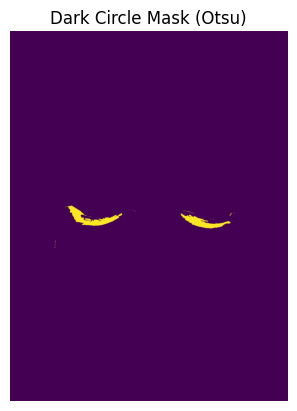

In [61]:

plt.imshow(dark_pixels_mask1)
plt.title('Dark Circle Mask (Otsu)')
plt.axis('off')
plt.show()